In [2]:
import numpy as np
from math import sqrt
from pprint import pprint
from sklearn import datasets
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
# Cargar y explorar los datos
datos = datasets.load_boston()
pprint(datos)
print(np.shape(datos.data))

{'DESCR': '.. _boston_dataset:\n'
          '\n'
          'Boston house prices dataset\n'
          '---------------------------\n'
          '\n'
          '**Data Set Characteristics:**  \n'
          '\n'
          '    :Number of Instances: 506 \n'
          '\n'
          '    :Number of Attributes: 13 numeric/categorical predictive. '
          'Median Value (attribute 14) is usually the target.\n'
          '\n'
          '    :Attribute Information (in order):\n'
          '        - CRIM     per capita crime rate by town\n'
          '        - ZN       proportion of residential land zoned for lots '
          'over 25,000 sq.ft.\n'
          '        - INDUS    proportion of non-retail business acres per '
          'town\n'
          '        - CHAS     Charles River dummy variable (= 1 if tract '
          'bounds river; 0 otherwise)\n'
          '        - NOX      nitric oxides concentration (parts per 10 '
          'million)\n'
          '        - RM       average num

In [4]:
# Extraer la matriz de datos "X" y la variable target "y"

X = datos.data
y = datos.target

In [5]:
# Partición EXTERNA: hold-out split 80% train - 20% test.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=42)

In [6]:
# Estandarización de los datos de entrenamiento y test
stdr = preprocessing.StandardScaler()
X_train = stdr.fit_transform(X_train)
X_test = stdr.transform(X_test)

In [7]:
# Métricas de evaluación.
metricas = {
  'MAE': 'neg_mean_absolute_error',
  'R2': 'r2',
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False)}

In [8]:
# Definimos un algoritmo SVM de regresión
from sklearn.svm import SVR
alg = SVR(C=50, gamma='auto', kernel='rbf')

#svc = SVC(C=1, gamma='auto', kernel='linear')

In [9]:
# Validación y evaluación del modelo.
# en "cv = KFold(n_splits=5)" se hace un cross-validation INTERNO!! 
results = cross_validate(alg, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring = metricas)

In [10]:
print(np.round(np.max(results['test_R2']),4))

0.9306


In [11]:
# Presentación de los resultados de la evaluación.
pprint(results)

{'fit_time': array([0.03071713, 0.01209974, 0.01104712, 0.01206946, 0.01021576]),
 'score_time': array([0.00299811, 0.00200033, 0.0029521 , 0.00199986, 0.00200677]),
 'test_MAE': array([-2.4820366 , -1.89764442, -2.6880301 , -2.39892713, -1.89858002]),
 'test_MAPE': array([-13.13091735,  -9.20477   , -11.08525005, -10.76882415,
       -11.18023812]),
 'test_R2': array([0.78705471, 0.93056802, 0.6480339 , 0.88227745, 0.90485517]),
 'test_RMSE': array([-3.89106507, -2.61137953, -5.59193598, -3.54826745, -2.51098123])}


In [12]:
print(np.round(np.mean(results['test_R2']),4))

0.8306


In [14]:
## Ejemplo propio para la búsqueda de parámetros optimos
from sklearn.model_selection import GridSearchCV

##Valores de C a evaluar
lista_c = [1] + list(range(5,200,5))
parametros= {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 
             'gamma':('auto', 'scale'),
             'C':lista_c}

grid_SVR = GridSearchCV(estimator=SVR(), #tipo de algoritmo SVR
                        param_grid = parametros, #parametros que queremos evaluar
                        cv = 5,     #Validación cruzada
                        n_jobs=-1, 
                        scoring='r2') #scoring con el queremos validar
grid_SVR.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60,
                               65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115,
                               120, 125, 130, 135, 140, 145, ...],
                         'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'rbf', 'sigmoid', 'poly')},
             scoring='r2')

In [15]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_SVR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_SVR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_SVR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 SVR(C=175, gamma='auto')

 The best score across ALL searched params:
 0.8902078772302806

 The best parameters across ALL searched params:
 {'C': 175, 'gamma': 'auto', 'kernel': 'rbf'}


In [16]:
sorted(grid_SVR.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_gamma',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [17]:
# Una vez hemos optimizado los hiperparámetros en el conjunto de validación, entrenamos un nuevo modelo que contenga
# todos los datos de entrenamiento (es decir, train + validation) para evaluar el test
model = SVR(C=175, gamma='auto', kernel='rbf')
model = model.fit(X_train, y_train)

In [19]:
# Extraemos el error absoluto promedio (MAE) del conjunto de test
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test results (MAE): ', mae)
print('Test results (r2): ', r2)

Test results (MAE):  2.1584930663598407
Test results (r2):  0.8303570610071995


In [20]:
# También podemos extraer las predicciones para cuánto difieren los valores predichos de los reales
print('Predicciones:   ', np.round(y_pred[:10], 1))
print('Valores reales: ', y_test[:10])

Predicciones:    [26.2 32.1 14.4 22.1 16.2 22.  19.4 15.7 21.8 19.7]
Valores reales:  [23.6 32.4 13.6 22.8 16.1 20.  17.8 14.  19.6 16.8]


In [105]:
# Grafica de realidad -vs- prediccion.
def grafica_real_vs_pred(y_true, y_pred, metricas, algoritmo):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.show()

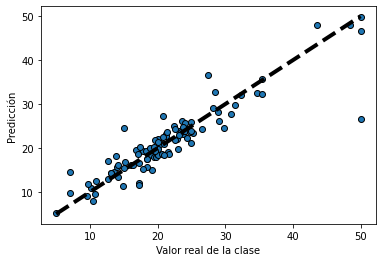

In [107]:
grafica_real_vs_pred(y_test, y_pred, metricas, model)